Found parallel files:
  spmv_output_128Pr.csv
  spmv_output_16Pr.csv
  spmv_output_1Pr.csv
  spmv_output_32Pr.csv
  spmv_output_64Pr.csv
  spmv_output_8Pr.csv

Serial times (n=5), max baseline used for speedup = 0.376304 s

Per-run table (each run's load imbalance, total exec and max/min comp time):


,file,path,procs,run_id,load_imbalance,total_exec_time,max_comp_time,min_comp_time
0,spmv_output_1Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_1Pr.csv,1,0,0.000000,1.735219245,0.368364800,0.368364800
1,spmv_output_1Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_1Pr.csv,1,1,0.000000,1.734293393,0.368176701,0.368176701
2,spmv_output_1Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_1Pr.csv,1,2,0.000000,1.734676310,0.368681640,0.368681640
3,spmv_output_1Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_1Pr.csv,1,3,0.000000,1.735426601,0.368574300,0.368574300
4,spmv_output_1Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_1Pr.csv,1,4,0.000000,1.734513906,0.368628955,0.368628955
5,spmv_output_8Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_8Pr.csv,8,0,0.000098,2.681308099,0.079542395,0.079534611
6,spmv_output_8Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_8Pr.csv,8,1,0.000054,2.682814422,0.079869810,0.079865480
7,spmv_output_8Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_8Pr.csv,8,2,0.000040,2.682846904,0.080008711,0.080005494
8,spmv_output_8Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_8Pr.csv,8,3,0.000139,2.679483920,0.079753542,0.079742435
9,spmv_output_8Pr.csv,C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\spmv_output_8Pr.csv,8,4,0.000044,2.680900489,0.079604141,0.079600637


Summary table (for plotting): show max/min across runs used for plotting and speedups:


,file,procs,num_runs_parsed,max_total_exec_over_runs,max_comp_time_over_runs,min_comp_time_over_runs,speedup_total_using_max,speedup_comp_using_max
0,spmv_output_1Pr.csv,1,5,1.735426601,0.368681640,0.368176701,0.216837,1.020675
1,spmv_output_8Pr.csv,8,5,2.682846904,0.080008711,0.079534611,0.140263,4.703288
2,spmv_output_16Pr.csv,16,5,2.773075786,0.062776793,0.061978742,0.135699,5.994317
3,spmv_output_32Pr.csv,32,5,3.512947614,0.060490033,0.059847586,0.107119,6.220926
4,spmv_output_64Pr.csv,64,5,4.513504654,0.065644806,0.065035163,0.083373,5.732426
5,spmv_output_128Pr.csv,128,5,10.743803392,0.100524266,0.011735440,0.035025,3.743415


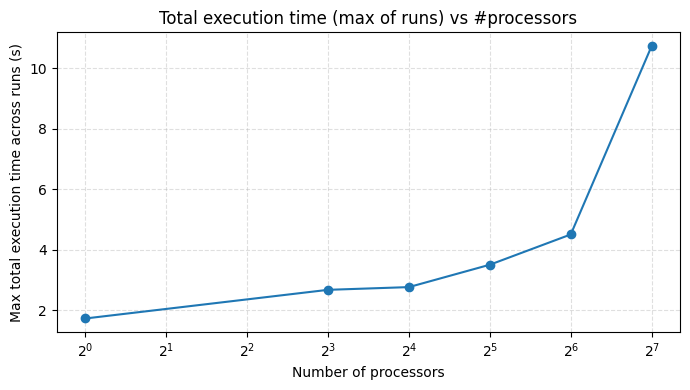

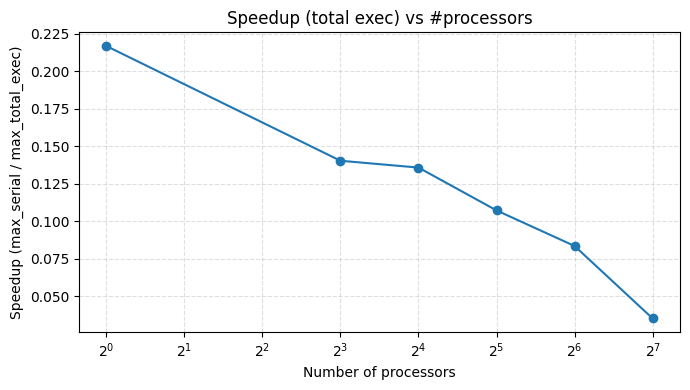

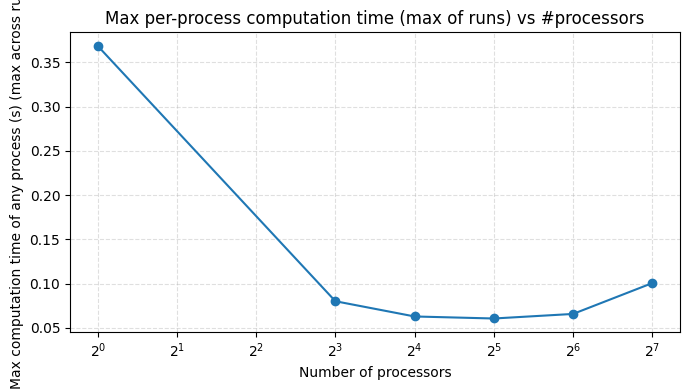

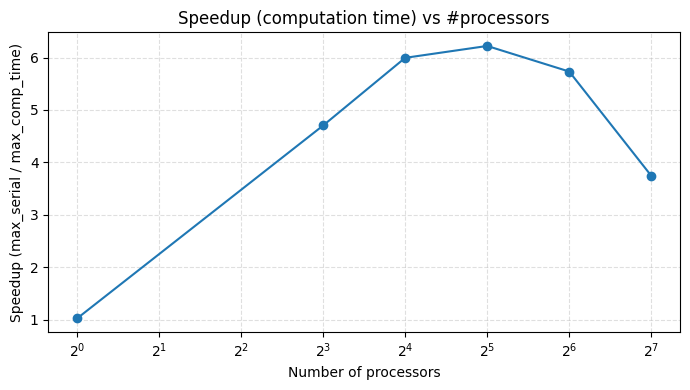

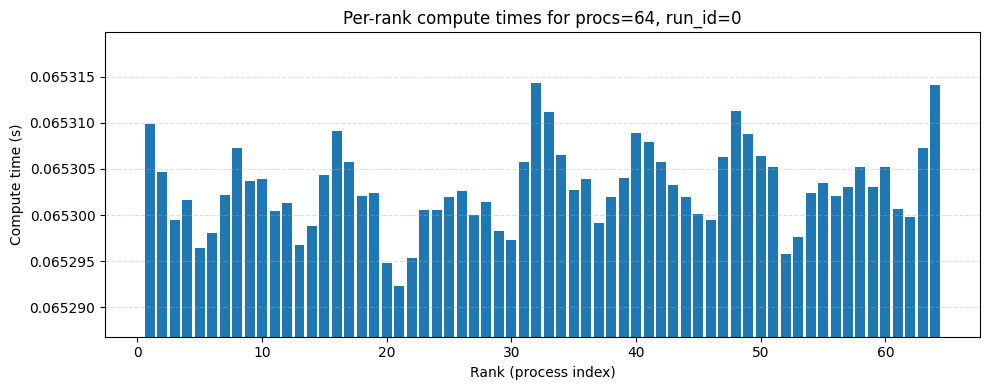

Done.


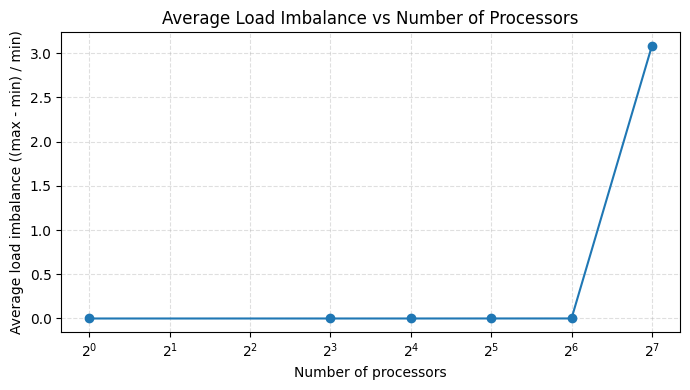

In [ ]:
# Cell: compute load-imbalance, min/max-values and plot the 4 requested graphs (zoom default = 64)
import os, glob, csv, re
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display









































































































































































































































base_dir = r"C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel"
serial_file = os.path.join(base_dir, "serial_spmv_output.csv")
# zoom per-rank plot target (None -> choose largest available). Default to 64 as requested.
zoom_proc_target = 64
# -----------------------------------

patterns = ["spmv_output*Pr*.csv", "spmv_output*Pr.csv", "spmv_output*_Pr*.csv",
            "spmv_output*process*.csv", "spmv_output*.csv"]

def find_parallel_files(base_dir):
    files = []
    for patt in patterns:
        files.extend(glob.glob(os.path.join(base_dir, patt)))
    files.extend(glob.glob(os.path.join(base_dir, "**", "spmv*.csv"), recursive=True))
    files = sorted(set([os.path.abspath(f) for f in files if "serial" not in os.path.basename(f).lower()]))
    return files

def extract_procs_from_name(fname):
    base = os.path.basename(fname)
    m = re.search(r'(\d+)\s*Pr', base, re.IGNORECASE) or re.search(r'(\d+)\s*Proc', base, re.IGNORECASE)
    if m:
        return int(m.group(1))
    nums = re.findall(r'(\d+)', base)
    if nums:
        return int(min([int(x) for x in nums]))  # choose smaller numeric token (likely procs)
    return -1

def parse_runblock(path):
    """
    Parse RunBlock file.
    Returns list of runs: each run is dict {run_id, rank_times:list, total_time_min, total_time_max, total_time_avg}
    """
    runs = []
    with open(path, "r", newline="") as f:
        reader = csv.reader(f)
        lines = [",".join(r).strip() for r in reader]
    i=0
    while i < len(lines):
        L = lines[i]
        if L.startswith("RunBlock,Run,"):
            parts = L.split(",")
            try:
                run_id = int(parts[2])
            except:
                run_id = parts[2] if len(parts)>=3 else None
            i += 1
            rank_times = []
            # gather Rank lines until Total Execution line
            while i < len(lines):
                S = lines[i]
                if S.startswith("Rank"):
                    p = S.split(",")
                    if len(p)>=2:
                        try:
                            rank_times.append(float(p[1]))
                        except:
                            pass
                    i += 1
                elif S.startswith("Total Execution time (s)"):
                    p = S.split(",")[1:]
                    nums = []
                    for x in p:
                        x = x.strip()
                        try:
                            nums.append(float(x))
                        except:
                            pass
                    tmin = nums[0] if len(nums)>=1 else None
                    tmax = nums[1] if len(nums)>=2 else None
                    tavg = nums[-1] if len(nums)>=1 else None
                    runs.append({
                        "run_id": run_id,
                        "rank_times": rank_times.copy(),
                        "total_time_min": tmin,
                        "total_time_max": tmax,
                        "total_time_avg": tavg
                    })
                    i += 1
                    break
                elif S.startswith("RunBlock,Run,") or S.startswith("RunBlock,"):
                    break
                else:
                    i += 1
            continue
        else:
            i += 1
    return runs

# discover files
parallel_files = find_parallel_files(base_dir)
if not parallel_files:
    raise SystemExit(f"No parallel spmv files found under {base_dir}. Adjust base_dir or place files there.")
print("Found parallel files:")
for f in parallel_files:
    print(" ", os.path.basename(f))
print()

# parse serial baseline
if not os.path.exists(serial_file):
    raise SystemExit(f"Serial file not found: {serial_file}")
serial_df = pd.read_csv(serial_file, comment='#', header=0)
# tolerant: find the numeric column for time
time_col = None
for c in serial_df.columns:
    if 'time' in c.lower():
        time_col = c; break
if time_col is None:
    # fallback to second column
    time_col = serial_df.columns[1]
serial_times = serial_df[time_col].astype(float).to_numpy()
max_serial_time = float(np.max(serial_times))
print(f"Serial times (n={len(serial_times)}), max baseline used for speedup = {max_serial_time:.6f} s\n")

# Collect per-run data across files
rows = []
summary_rows = []
perproc_runs_store = {}  # procs -> runs list (for zoom plot)
for f in parallel_files:
    procs = extract_procs_from_name(f)
    runs = parse_runblock(f)
    if not runs:
        print(f"Warning: no runs parsed from {f}")
        continue
    perproc_runs_store[procs] = runs
    # For each run compute load imbalance and max/min rank comp
    for r in runs:
        ranks = r.get("rank_times", [])
        if len(ranks)==0:
            li = np.nan
            max_comp = np.nan
            min_comp = np.nan
        else:
            max_comp = float(np.max(ranks))
            min_comp = float(np.min(ranks))
            li = (max_comp - min_comp)/min_comp if min_comp!=0 else np.nan
        total_exec = r.get("total_time_avg", np.nan)
        rows.append({
            "file": os.path.basename(f),
            "path": f,
            "procs": procs,
            "run_id": r.get("run_id"),
            "load_imbalance": li,
            "total_exec_time": total_exec,
            "max_comp_time": max_comp,
            "min_comp_time": min_comp
        })
    # summary per file (max/min across the 5 runs as requested)
    total_execs = [float(r.get("total_time_avg")) for r in runs if r.get("total_time_avg") is not None]
    max_comp_runs = [float(np.max(r.get("rank_times"))) if r.get("rank_times") else np.nan for r in runs]
    min_comp_runs = [float(np.min(r.get("rank_times"))) if r.get("rank_times") else np.nan for r in runs]
    summary_rows.append({
        "file": os.path.basename(f),
        "procs": procs,
        "num_runs_parsed": len(runs),
        "max_total_exec_over_runs": float(np.max(total_execs)) if total_execs else np.nan,
        "max_comp_time_over_runs": float(np.nanmax(max_comp_runs)) if max_comp_runs else np.nan,
        "min_comp_time_over_runs": float(np.nanmin(min_comp_runs)) if min_comp_runs else np.nan
    })

# DataFrames
df_runs = pd.DataFrame(rows).sort_values(["procs","run_id"]).reset_index(drop=True)
df_summary = pd.DataFrame(summary_rows).sort_values("procs").reset_index(drop=True)

# Compute speedups using max_serial_time
df_summary["speedup_total_using_max"] = max_serial_time / df_summary["max_total_exec_over_runs"]
df_summary["speedup_comp_using_max"] = max_serial_time / df_summary["max_comp_time_over_runs"]

# Display the per-run table (load imbalance for each run)
print("Per-run table (each run's load imbalance, total exec and max/min comp time):")
display(df_runs.style.format({
    "load_imbalance": "{:.6f}",
    "total_exec_time": "{:.9f}",
    "max_comp_time": "{:.9f}",
    "min_comp_time": "{:.9f}"
}))

print("Summary table (for plotting): show max/min across runs used for plotting and speedups:")
display(df_summary.style.format({
    "max_total_exec_over_runs": "{:.9f}",
    "max_comp_time_over_runs": "{:.9f}",
    "min_comp_time_over_runs": "{:.9f}",
    "speedup_total_using_max": "{:.6f}",
    "speedup_comp_using_max": "{:.6f}"
}))

# ---- PLOTS: 4 graphs inline ----
procs = df_summary["procs"].astype(int).to_numpy()
# ensure sorted
order = np.argsort(procs)
procs = procs[order]
max_total = df_summary["max_total_exec_over_runs"].to_numpy()[order]
speedup_total = df_summary["speedup_total_using_max"].to_numpy()[order]
max_comp = df_summary["max_comp_time_over_runs"].to_numpy()[order]
speedup_comp = df_summary["speedup_comp_using_max"].to_numpy()[order]

plt.rcParams.update({'figure.autolayout': True})

# 1) Total execution time (max across runs) vs procs
plt.figure(figsize=(7,4))
plt.plot(procs, max_total, marker='o', linestyle='-')
plt.xscale('log', base=2)
plt.xlabel('Number of processors')
plt.ylabel('Max total execution time across runs (s)')
plt.title('Total execution time (max of runs) vs #processors')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# 2) Speedup (based on total exec max)
plt.figure(figsize=(7,4))
plt.plot(procs, speedup_total, marker='o', linestyle='-')
plt.xscale('log', base=2)
plt.xlabel('Number of processors')
plt.ylabel(f'Speedup (max_serial / max_total_exec)')
plt.title('Speedup (total exec) vs #processors')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# 3) Max computation time (max across runs) vs procs
plt.figure(figsize=(7,4))
plt.plot(procs, max_comp, marker='o', linestyle='-')
plt.xscale('log', base=2)
plt.xlabel('Number of processors')
plt.ylabel('Max computation time of any process (s) (max across runs)')
plt.title('Max per-process computation time (max of runs) vs #processors')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# 4) Speedup (based on computation time max)
plt.figure(figsize=(7,4))
plt.plot(procs, speedup_comp, marker='o', linestyle='-')
plt.xscale('log', base=2)
plt.xlabel('Number of processors')
plt.ylabel(f'Speedup (max_serial / max_comp_time)')
plt.title('Speedup (computation time) vs #processors')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.show()

# ---- Zoomed per-rank bar plot for run 0 of target proc count (default 64) ----
# choose fallback target if 64 not available
if zoom_proc_target is None:
    target = max(perproc_runs_store.keys())
else:
    target = zoom_proc_target if zoom_proc_target in perproc_runs_store else (max(perproc_runs_store.keys()) if perproc_runs_store else None)

if target is None:
    print("No per-rank data available; skipping zoomed bar plot.")
elif target not in perproc_runs_store:
    print(f"No per-rank data available for {target} procs; skipping zoomed bar plot.")
else:
    runs_for_target = perproc_runs_store[target]
    # choose run with run_id == 0 if available, else first run
    chosen = None
    for r in runs_for_target:
        if r.get("run_id") == 0:
            chosen = r; break
    if chosen is None:
        chosen = runs_for_target[0]
    ranks = chosen.get("rank_times", [])
    if not ranks:
        print("No rank times found for chosen run; skipping per-rank plot.")
    else:
        ranks_arr = np.array(ranks)
        idxs = np.arange(len(ranks_arr)) + 1
        plt.figure(figsize=(10,4))
        plt.bar(idxs, ranks_arr)
        plt.xlabel("Rank (process index)")
        plt.ylabel("Compute time (s)")
        plt.title(f"Per-rank compute times for procs={target}, run_id={chosen.get('run_id')}")
        # zoom: set tight y-limits around the median to emphasize small differences
        med = np.median(ranks_arr)
        rng = (np.max(ranks_arr)-np.min(ranks_arr))
        if rng == 0:
            plt.ylim(med-1e-6, med+1e-6)
        else:
            pad = max(rng*0.25, 1e-6)  # show +/- 25% of range
            plt.ylim(np.min(ranks_arr)-pad, np.max(ranks_arr)+pad)
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.show()

print("Done.")

# ---- Load imbalance plot (average per processor count) ----

# Compute avg load imbalance for each processor count
load_df = df_runs.groupby("procs")["load_imbalance"].mean().reset_index()
load_df = load_df.sort_values("procs")

plt.figure(figsize=(7,4))
plt.plot(load_df["procs"], load_df["load_imbalance"], marker="o")
plt.xscale("log", base=2)
plt.xlabel("Number of processors")
plt.ylabel("Average load imbalance ((max - min) / min)")
plt.title("Average Load Imbalance vs Number of Processors")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()



In [11]:
# --- Add avg (and max) load-imbalance to the summary table ---
# (run this after you have df_runs and df_summary defined as in your cell)

# compute per-proc load-imbalance aggregates from df_runs (li computed per run already)
li_agg = df_runs.groupby("procs")["load_imbalance"].agg(
    avg_load_imbalance = "mean",
    max_load_imbalance = "max"
).reset_index()

# merge into df_summary on 'procs'
df_summary = df_summary.merge(li_agg, on="procs", how="left")

# optional: also compute a "min_load_imbalance" if you want the smallest of the five runs
min_li = df_runs.groupby("procs")["load_imbalance"].min().reset_index().rename(columns={"load_imbalance":"min_load_imbalance"})
df_summary = df_summary.merge(min_li, on="procs", how="left")

# display updated table (same order as your example)
display_cols = [
    "file","procs","num_runs_parsed",
    "max_total_exec_over_runs","max_comp_time_over_runs","min_comp_time_over_runs",
    "avg_load_imbalance","max_load_imbalance","min_load_imbalance",
    "speedup_total_using_max","speedup_comp_using_max"
]
# ensure columns exist (in case you don't want min/max shown, you can drop them)
for c in display_cols:
    if c not in df_summary.columns:
        df_summary[c] = np.nan

# show nicely formatted
pd.options.display.float_format = '{:.9f}'.format
print("Updated summary with load-imbalance (avg / max / min):")
display(df_summary[display_cols].sort_values("procs").reset_index(drop=True))

# (optional) save to CSV
# df_summary.to_csv("combined_summary_with_loadimb.csv", index=False)


Updated summary with load-imbalance (avg / max / min):


,file,procs,num_runs_parsed,max_total_exec_over_runs,max_comp_time_over_runs,min_comp_time_over_runs,avg_load_imbalance,max_load_imbalance,min_load_imbalance,speedup_total_using_max,speedup_comp_using_max
0,spmv_output_1Pr.csv,1,5,1.735426601,0.368681640,0.368176701,0.000000000,0.000000000,0.000000000,0.216836598,1.020674640
1,spmv_output_8Pr.csv,8,5,2.682846904,0.080008711,0.079534611,0.000075120,0.000139286,0.000040210,0.140262942,4.703287871
2,spmv_output_16Pr.csv,16,5,2.773075786,0.062776793,0.061978742,0.000105593,0.000246343,0.000037876,0.135699140,5.994317040
3,spmv_output_32Pr.csv,32,5,3.512947614,0.060490033,0.059847586,0.000318300,0.000568210,0.000216548,0.107119161,6.220925685
4,spmv_output_64Pr.csv,64,5,4.513504654,0.065644806,0.065035163,0.000465785,0.000743145,0.000322719,0.083372906,5.732426112
5,spmv_output_128Pr.csv,128,5,10.743803392,0.100524266,0.011735440,3.080484772,5.883660263,1.885381202,0.035025213,3.743414550
